In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
import catboost as cbt

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler as std

pd.set_option('display.max_columns', None)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [3]:
path = './'
train = pd.read_csv(path+'input/train.csv')
test = pd.read_csv(path+'input/test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [7]:
import seaborn as sns
%matplotlib inline

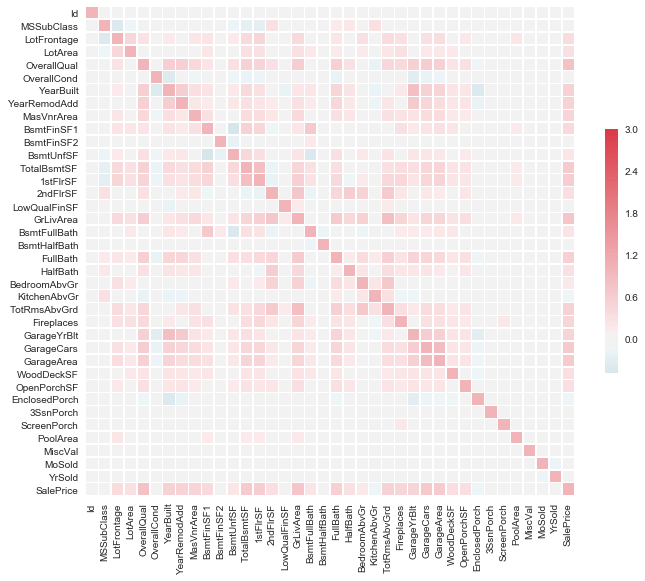

In [8]:
sns.set(style='white')
corr = train.corr()
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=3, center=0, square=True, linewidths=.5, cbar_kws={'shrink':.5})
plt.show()

In [10]:
features = [i for i in train.columns if i not in ['Id', 'SalePrice']]
cat_col = [i for i in train.select_dtypes('object') if i not in ['Id', 'SalePrice']]
len(features), len(cat_col)

(79, 43)

In [11]:
test['SalePrice'] = -1
data = train.append(test).reset_index(drop=True)

In [13]:
len(data), len(train), len(test)

(2919, 1460, 1459)

In [21]:
data_null = data.isnull().sum()/len(data) * 100
data_null = data_null.drop(data_null[data_null==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': data_null})
missing_data.head(40), len(missing_data)

(              Missing Ratio
 PoolQC            99.657417
 MiscFeature       96.402878
 Alley             93.216855
 Fence             80.438506
 FireplaceQu       48.646797
 LotFrontage       16.649538
 GarageFinish       5.447071
 GarageYrBlt        5.447071
 GarageQual         5.447071
 GarageCond         5.447071
 GarageType         5.378554
 BsmtExposure       2.809181
 BsmtCond           2.809181
 BsmtQual           2.774923
 BsmtFinType2       2.740665
 BsmtFinType1       2.706406
 MasVnrType         0.822199
 MasVnrArea         0.787941
 MSZoning           0.137033
 BsmtFullBath       0.068517
 BsmtHalfBath       0.068517
 Utilities          0.068517
 Functional         0.068517
 Exterior2nd        0.034258
 Exterior1st        0.034258
 SaleType           0.034258
 BsmtFinSF1         0.034258
 BsmtFinSF2         0.034258
 BsmtUnfSF          0.034258
 Electrical         0.034258
 KitchenQual        0.034258
 GarageCars         0.034258
 GarageArea         0.034258
 TotalBsmtSF  

In [22]:
#填充NULL值
for i in features:
    if data[i].isnull().sum() != 0:
        if i in cat_col:
            data[i] = data[i].fillna('None')
        else:
            data[i] = data[i].fillna(0)
#分类对象处理
for i in cat_col:
    data[i] = LabelEncoder().fit_transform(data[i])

In [45]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,4,65.0,8450,1,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,13,14,1,196.0,2,4,2,2,4,3,2,706.0,6,0.0,150.0,856.0,1,0,1,5,856,854,0,1710,1.0,0.0,2,1,3,1,2,8,7,0,3,1,2003.0,2,2.0,548.0,5,5,2,0,61,0,0,0,0,3,4,1,0,2,2008,9,4,208500
1,2,20,4,80.0,9600,1,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,4,1,0,978.0,6,0.0,284.0,1262.0,1,0,1,5,1262,0,0,1262,0.0,1.0,2,0,3,1,4,6,7,1,5,1,1976.0,2,2.0,460.0,5,5,2,298,0,0,0,0,0,3,4,1,0,5,2007,9,4,181500
2,3,60,4,68.0,11250,1,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,13,14,1,162.0,2,4,2,2,4,2,2,486.0,6,0.0,434.0,920.0,1,0,1,5,920,866,0,1786,1.0,0.0,2,1,3,1,2,6,7,1,5,1,2001.0,2,2.0,608.0,5,5,2,0,42,0,0,0,0,3,4,1,0,9,2008,9,4,223500
3,4,70,4,60.0,9550,1,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,14,16,2,0.0,3,4,0,4,1,3,0,216.0,6,0.0,540.0,756.0,1,2,1,5,961,756,0,1717,1.0,0.0,1,0,3,1,2,7,7,1,2,5,1998.0,3,3.0,642.0,5,5,2,0,35,272,0,0,0,3,4,1,0,2,2006,9,0,140000
4,5,60,4,84.0,14260,1,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,13,14,1,350.0,2,4,2,2,4,0,2,655.0,6,0.0,490.0,1145.0,1,0,1,5,1145,1053,0,2198,1.0,0.0,2,1,4,1,2,9,7,1,5,1,2000.0,2,3.0,836.0,5,5,2,192,84,0,0,0,0,3,4,1,0,12,2008,9,4,250000


In [62]:
import lightgbm as lgb
import catboost as cbt
import xgboost as xgb

xgb_model_cls = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=6,
    min_child_weight=1, subsample=0.8, colsample_bylevel=0.8, objective='binary:logistic',
    random_state=23, reg_alpha=0, reg_lambda=1)

lgb_model_cls = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=32, reg_alpha=0.0,
    reg_lambda=0.0, max_depth=-1, n_estimators=1500, objective='binary', metric='auc',
    subsample=0.95, colsample_bytree=0.95, subsample_freq=1, learning_rate=0.05,
    random_state=25)

cbt_model_cls = cbt.CatBoostClassifier(iterations=5000, learning_rate=0.1, max_depth=7, 
    l2_leaf_reg=1, verbose=100, early_stopping_rounds=500, task_type='CPU',
    eval_metric='F1')#, cat_features=cat_list)

In [63]:
xgb_model_reg = xgb.XGBRegressor(max_depth=8, learning_rate=0.1, n_estimators=160, 
    silent=False)
lgb_model_reg = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, reg_alpha=10,
    reg_lambda=5, max_depth=7, n_estimators=500, subsample=0.7, colsample_bytree=0.4,
    subsample_freq=2, min_child_samples=10, learning_rate=0.05, random_state=2019)
cbt_model_reg = cbt.CatBoostRegressor(iterations=10, depth=5, learning_rate=0.1,
    loss_function='RMSE')

In [65]:
xgb_model_reg.fit?

In [64]:
data.describe()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.00000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,3.968825,57.766701,10168.114080,0.995889,0.985612,1.947585,2.776978,0.001713,3.055841,0.053786,12.437136,2.040425,2.002055,0.505653,3.026721,6.089072,5.564577,1971.312778,1984.264474,1.396369,1.063035,10.225420,10.954779,1.767044,101.396026,2.530661,3.708804,1.393285,2.699897,3.674203,2.327509,3.182939,441.272011,5.549846,49.565262,560.579993,1051.417266,1.025351,1.533744,0.932854,4.600206,1159.581706,336.483727,4.694416,1500.759849,0.429599,0.061322,1.568003,0.380267,2.860226,1.044536,2.858171,6.451524,6.690647,0.597122,3.07160,2.483727,1870.364166,1.874272,1.766016,472.712573,4.689620,4.764303,1.830764,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,2.993148,3.493662,1.065776,50.825968,6.213087,2007.792737,8.358342,3.779034,90491.088386
std,842.787043,42.517628,0.858407,33.481636,7886.996359,0.063996,0.260092,1.409721,0.704391,0.055510,1.604472,0.248750,5.957992,0.874047,0.209431,1.206513,1.912937,1.409947,1.113131,30.291442,20.894344,0.820906,0.539210,3.634221,3.991253,0.605433,178.854579,0.702245,0.773641,0.727061,1.296263,0.976974,1.151168,2.235172,455.606014,1.273511,169.179104,439.590889,441.120498,0.245678,1.742548,0.250318,1.323386,392.362079,428.701456,46.396825,506.051045,0.524676,0.245608,0.552969,0.502872,0.822693,0.214462,1.270383,1.569379,1.177475,0.646129,1.14507,1.932814,449.686321,1.202416,0.762196,215.535686,0.950235,0.803061,0.537299,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,0.128073,1.091376,0.363410,567.402211,2.714762,1.314964,1.879617,1.078241,106496.804191
min,1.000000,20.000000,0.000000,0.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [66]:
KFold?

In [ ]:
def get_pred_reg(model, data, label='label', model_type='lgb',random_state=2019,
                n_splits=5, featore=[]):
    model.random_state=random_state
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    test_data

In [67]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])

In [79]:
kfold = KFold(n_splits=3, shuffle=True)

for i, j in kfold.split(X):
    print(i, ' ', j)

[0 2]   [1 3]
[1 2 3]   [0]
[0 1 3]   [2]


In [80]:
kfold.split?